In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import dual_annealing
from scipy.optimize import least_squares

In [2]:
'''
April 9: Add multiple trials for nonlinear least squares.
'''

'\nApril 9: Add multiple trials for nonlinear least squares.\n'

In [3]:
def solve_vdp(K, MU, N):
    '''
    Solve the coupled VDP eqn for a given set of params, K and MU.
    
    MU == 0. ... 0. -> reduces to simple harmonic motion.
    
    N - number of coupled masses.
    '''
    t0, tf = 0., 8. # initial and final integration times
    nframes = 2 ** 8 # number of time steps

    d = 6. # distance between rest positions (uniform)
    
    # set rest positions of springs + boards
    R = np.arange(0, d *(N + 1 + 1), d, dtype=np.float_)

    # set initial positions of springs
    X = np.copy(R)
    X[1] -= 1.8 
    X[-2] -= 2.4

    # Set up the linear system.
    XV = np.zeros(2 * N)
    XV[:N] = X[1:-1] # Initial positions of the springs
    XV[N:] = np.zeros(N) # initial velocities of the springs
    
    # Acceleration function
    F_accel = lambda DX, XV: -K * (DX[1:-1] - DX[:-2]) + \
        K * (DX[2:] - DX[1:-1]) + MU * (1 - np.power(DX[1:-1], 2)) * XV[N:]
    
    # Wrapper on F_accel, which operates on DX, to operate on XV = DX, V instead
    def F(t, XV):
        DX = np.hstack( ([0.], XV[:N], [X[-1]]) ) - R 
        res = np.hstack(( XV[N:], F_accel(DX, XV) ) 
                        )
        return res
    
    # Use SciPy timestepping to solve the problem.
    soln = solve_ivp(F, [t0, tf], XV,
                    t_eval=np.linspace(t0,tf,nframes))
    return soln


In [4]:
def solve_vdp_demo(N=5):
    # Default values for the VDP solver
    K = (np.arange(N) - N / 3) ** 2. #np.ones(N)
    K[1] += 1 #lolol
    K[2] += 1
    MU = 0.5 * np.ones(N)
    print(f'K == {K}')
    print(f'MU == {MU}')
    return solve_vdp(K, MU, N), N

def plot_trails(solny, N, dots=False, save=False, savename=''):
    for i in range(N):
        if dots:
            plt.plot(solny[i, :], soln.t, 'bo')
        else:
            plt.plot(solny[i, :], soln.t)
        
        if save:
            plt.savefig(savename, dpi=256)
    return

data_ptr = []

K == [2.77777778 1.44444444 1.11111111 1.77777778 5.44444444]
MU == [0.5 0.5 0.5 0.5 0.5]
7.252779394488011


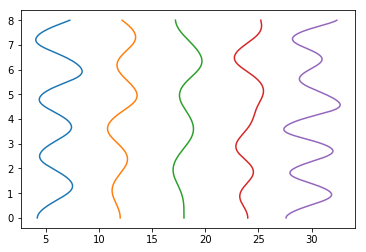

In [5]:
soln, N = solve_vdp_demo()
plot_trails(soln.y, N, save=True, savename='assets/vdp_anneal_exact.png')

print(soln.y[0,-1])

K == [2.77777778 1.44444444 1.11111111 1.77777778 5.44444444]
MU == [0.5 0.5 0.5 0.5 0.5]


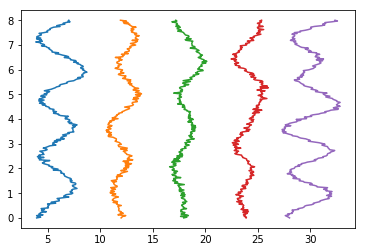

In [6]:
def add_noise(data, noise_param=0.2):
    noise = np.random.standard_normal(data.y.shape)
    noisy_data = data.y + noise_param * noise
    return noisy_data

# Testing a way to generate noisy data once and keeping it in the cell.
def generate_data(data_ptr):
    if data_ptr:
        return
    else:
        data, N = solve_vdp_demo()
        noised_data = add_noise(data)
        data_ptr.append( data.t )
        data_ptr.append( noised_data )
        
generate_data(data_ptr)

plot_trails(data_ptr[1], N, save=True, savename='vdp_anneal_perturbed')

In [7]:

def curve_diffs(params, N, Tdata, Ydata, *args):
    '''
    Solve the VDP for the current params and compare it to the data.
    Return the cost of the VDP soln with the given params.
    '''
    K = params #MU = params[:N], params[N:]
    MU = np.ones(N) * 0.5 # let's make it easier for you..
    
    soln = solve_vdp(K, MU, N) # Don't actually need to use Tdata
    
    error = np.sqrt( np.sum( (soln.y - Ydata) ** 2 ) )
    return error

In [12]:
%%time

from scipy.optimize import least_squares

# Do the thing for nonlinear least squares.
Ydata = data_ptr[1]
tdata = data_ptr[0]
N = 5

Kmins = np.zeros(N)
Kmaxes = np.ones(N)* 50

Niters = 10

best_k = None
best_cost = np.inf
fullres = None # the full lsq object... in case if I need this data later

for i in range(Niters):
    # uniformly sample a number between kmins and kmaxes
    sample_pt = np.random.rand(N) * Kmaxes # If Kmins is not all zeros, need to do a linear interpolant
    IC = sample_pt 
    # nonlinear least squares
    print(f'Iter {i}: Initial guess is {IC}')
    res_lsq = least_squares(curve_diffs, IC, args=(N, tdata, Ydata))

    cost_found = res_lsq.cost
    k_found = res_lsq.x
    
    if cost_found < best_cost:
        best_cost = cost_found
        best_k = k_found
        fullres = res_lsq
        

    

print(fullres)

Iter 0: Initial guess is [29.55523935  8.60598121 42.64228442 12.15327825 49.92098386]
Iter 1: Initial guess is [40.22879541 19.62507707 34.19050921 38.60907584 39.94285478]
Iter 2: Initial guess is [13.54673438 42.31916827 33.63722284 24.01062767  5.75609008]
Iter 3: Initial guess is [ 7.86748704 24.46489414  6.94398818  5.26963351  1.35506819]
Iter 4: Initial guess is [43.87037554  0.5547131  41.52601064 28.52006829 18.50951392]
Iter 5: Initial guess is [32.40792737 29.04191766 13.12312082  9.43566854 26.09676484]
Iter 6: Initial guess is [ 8.73936107  3.04174842 21.26719588 10.36838905 14.09471659]
Iter 7: Initial guess is [11.07046841  9.03969563 16.62868814 24.03220558 29.94438391]
Iter 8: Initial guess is [31.01044917 37.67706465 32.06372376 39.76306716 40.82169523]
Iter 9: Initial guess is [27.31532754 29.97537308 21.75386701 42.65187867 28.09079316]
 active_mask: array([0., 0., 0., 0., 0.])
        cost: 10847.645793796755
         fun: array([147.29321637])
        grad: array

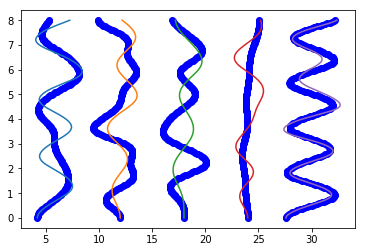

In [16]:
k_found = fullres.x

lsq_guess_soln = solve_vdp(k_found, np.ones(N) * 0.5, N)

plot_trails(lsq_guess_soln.y, N, dots=True)
plot_trails(soln.y, N)

plt.savefig('assets/vdp_nls.png',dpi=256)



# way faster, but only finds a local optimum?

In [14]:
%%time

# Do the thing for nonlinear least squares.
Ydata = data_ptr[1]
tdata = data_ptr[0]
N = 5

# Same as prev, but use a much smaller region.
Kmins = np.zeros(N)
Kmaxes = np.ones(N)* 10

Niters = 10

best_k = None
best_cost = np.inf
fullres = None # the full lsq object... in case if I need this data later

for i in range(Niters):
    # uniformly sample a number between kmins and kmaxes
    sample_pt = np.random.rand(N) * Kmaxes # If Kmins is not all zeros, need to do a linear interpolant
    IC = sample_pt 
    # nonlinear least squares
    print(f'Iter {i}: Initial guess is {IC}')
    res_lsq = least_squares(curve_diffs, IC, args=(N, tdata, Ydata))

    cost_found = res_lsq.cost
    k_found = res_lsq.x
    
    if cost_found < best_cost:
        best_cost = cost_found
        best_k = k_found
        fullres = res_lsq
        

    

print(fullres)

Iter 0: Initial guess is [0.54461139 7.39701254 3.42572237 8.54526917 8.4326173 ]
Iter 1: Initial guess is [4.77910639 2.49262752 6.6752279  9.86215764 2.63898211]
Iter 2: Initial guess is [4.6238478  9.07783992 3.30352611 2.49779258 9.53534866]
Iter 3: Initial guess is [8.90581116 3.29451122 5.07655267 5.49529291 8.53550941]
Iter 4: Initial guess is [1.93389435 7.19913731 1.02693678 0.95139793 6.1336077 ]
Iter 5: Initial guess is [4.69536911 3.49038049 6.1742267  6.78939797 9.6757177 ]
Iter 6: Initial guess is [0.80161883 7.56425255 3.09036208 5.96092357 2.63042631]
Iter 7: Initial guess is [8.1876488  6.79873849 4.08166617 9.18192265 2.90237441]
Iter 8: Initial guess is [6.39864338 0.74590538 4.6673452  4.28327049 3.83789948]
Iter 9: Initial guess is [2.99730399 7.26095965 5.7145447  0.28016229 4.77381366]
 active_mask: array([0., 0., 0., 0., 0.])
        cost: 4082.2279637241336
         fun: array([90.35737893])
        grad: array([560.29356595, 156.34881846, -21.49169959, 533.242

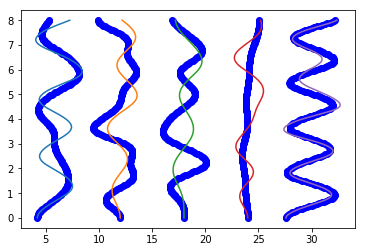

In [15]:
k_found = fullres.x

lsq_guess_soln = solve_vdp(k_found, np.ones(N) * 0.5, N)

plot_trails(lsq_guess_soln.y, N, dots=True)
plot_trails(soln.y, N)

# way faster, but only finds a local optimum?